/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 99ms/step - loss: 0.5457 - val_loss: 0.4918
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 95ms/step - loss: 0.4906 - val_loss: 0.4914
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 97ms/step - loss: 0.4910 - val_loss: 0.4914
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 99ms/step - loss: 0.4901 - val_loss: 0.4915
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - loss: 0.4903 - val_loss: 0.4914
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 97ms/step - loss: 0.4912 - val_loss: 0.4913
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - loss: 0.4907 - val_loss: 0.4914
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 98ms/step - loss: 0.4904 - val_loss: 0.4912
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - loss: 0.4905 - val_loss: 0.4913
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - loss: 0.4908 - val_loss: 0.4914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━

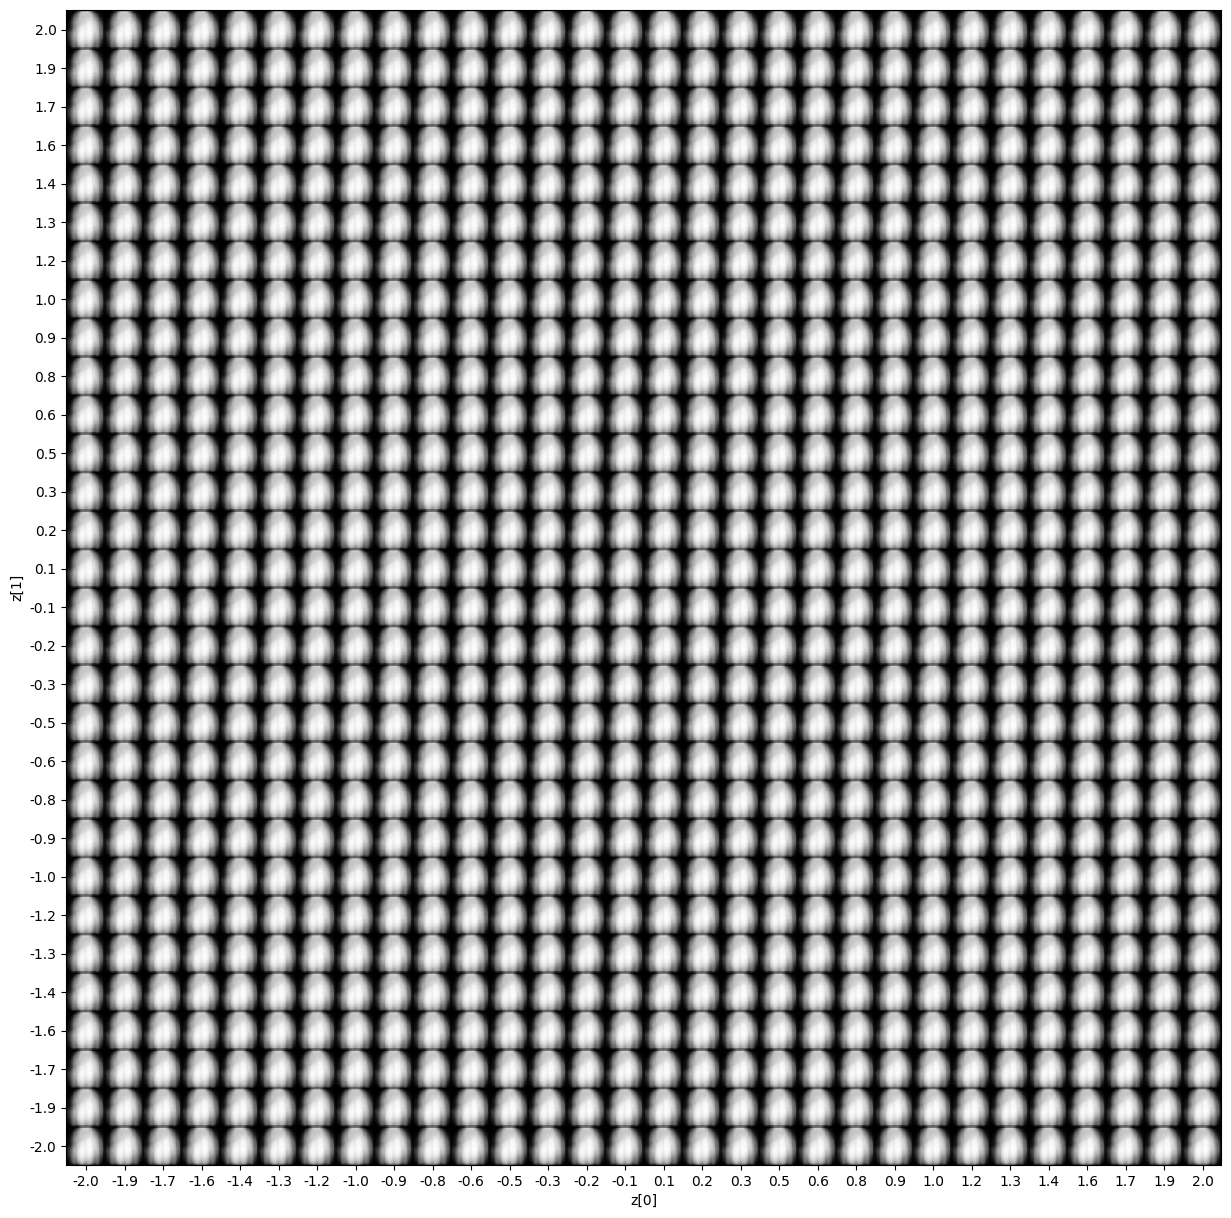

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


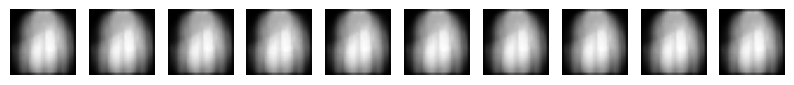

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess Fashion MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Define VAE architecture
latent_dim = 2  # Dimensionality of the latent space

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(models.Model):
    def __init__(self, latent_dim):  # ✅ Fixed __init__ method
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_inputs = layers.Input(shape=(784,))
        x = layers.Dense(256, activation='relu')(self.encoder_inputs)
        x = layers.Dense(128, activation='relu')(x)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        self.encoder = models.Model(self.encoder_inputs, [z_mean, z_log_var, z], name="encoder")

        # Decoder
        latent_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(128, activation='relu')(latent_inputs)
        x = layers.Dense(256, activation='relu')(x)
        decoder_outputs = layers.Dense(784, activation='sigmoid')(x)
        self.decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # ✅ Ensure KL divergence loss works correctly
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(tf.reduce_mean(kl_loss))

        return reconstructed

# ✅ Enable eager execution (Colab compatibility)
tf.config.run_functions_eagerly(True)

# Compile and train the VAE
vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
vae.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))

vae.save_weights('vae_fashion_mnist.weights.h5')

# Function to explore the latent space
def plot_latent_space(vae, n=30, figsize=15):
    scale = 2.0
    figure = np.zeros((28 * n, 28 * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = 28 // 2
    end_range = n * 28 + start_range
    pixel_range = np.arange(start_range, end_range, 28)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

plot_latent_space(vae)

# Function to interpolate in latent space
def interpolate_latent_space(vae, x1, x2, num_steps=10):
    z_mean1, _, _ = vae.encoder(x1)
    z_mean2, _, _ = vae.encoder(x2)

    # ✅ Ensure numpy conversion is done properly
    z_mean1 = z_mean1.numpy()
    z_mean2 = z_mean2.numpy()

    interpolated_z = np.linspace(z_mean1, z_mean2, num_steps)

    print("Shape of interpolated_z:", interpolated_z.shape)

    interpolated_images = vae.decoder.predict(interpolated_z)

    plt.figure(figsize=(15, 3))
    for i, img in enumerate(interpolated_images):
        ax = plt.subplot(1, num_steps, i + 1)
        plt.imshow(img.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Function to generate new samples
def generate_new_samples(vae, num_samples=10):
    random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
    generated_images = vae.decoder.predict(random_latent_vectors)

    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

generate_new_samples(vae)
